# $Modeling$

## Imports

In [44]:
import numpy as np
import pandas as pd
from scipy import stats
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoLars
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor

import seaborn as sns
import matplotlib.pyplot as plt
import wrangle as w
import explore as e

# 1. Select a dataset with a continuous target variable.

In [2]:
# wrangel zillow data
df = w.wrangle_single_family_residential()

In [3]:
df = w.remove_outliers(df,['bedroom','bathroom','squarefeet','taxamount','tax_value'])

# 2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

In [4]:
# Split data to train , test validate, using random state 123
train, validate, test = w.split_data(df)

In [5]:
train.dtypes

bedroom       float64
bathroom      float64
squarefeet    float64
tax_value     float64
yearbuilt     float64
taxamount     float64
fips           object
home_age      float64
dtype: object

# 3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [6]:
# set up dataframe for predictions, add actual values
predictions = pd.DataFrame({
    'actual': validate.tax_value
}) 

In [7]:
predictions.head()

,actual
1292142,224327.0
2058386,146000.0
1883615,489000.0
1580431,269076.0
711630,104263.0


### **Simple Model**

In [8]:
# X must be 2-d array
X_train = train[['taxamount']]
# y can be 1-d array
y_train = train.tax_value

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
X_validate = validate[['taxamount']]
predictions['simple_lm'] = lm.predict(X_validate)

In [9]:
predictions.head()

,actual,simple_lm
1292142,224327.0,216633.023808
2058386,146000.0,204330.521354
1883615,489000.0,481736.907417
1580431,269076.0,253885.366359
711630,104263.0,111585.069010


In [10]:
# look into modesl make up 
lm.coef_, lm.intercept_

(array([84.51842851]), -16365.68954562716)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


/opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


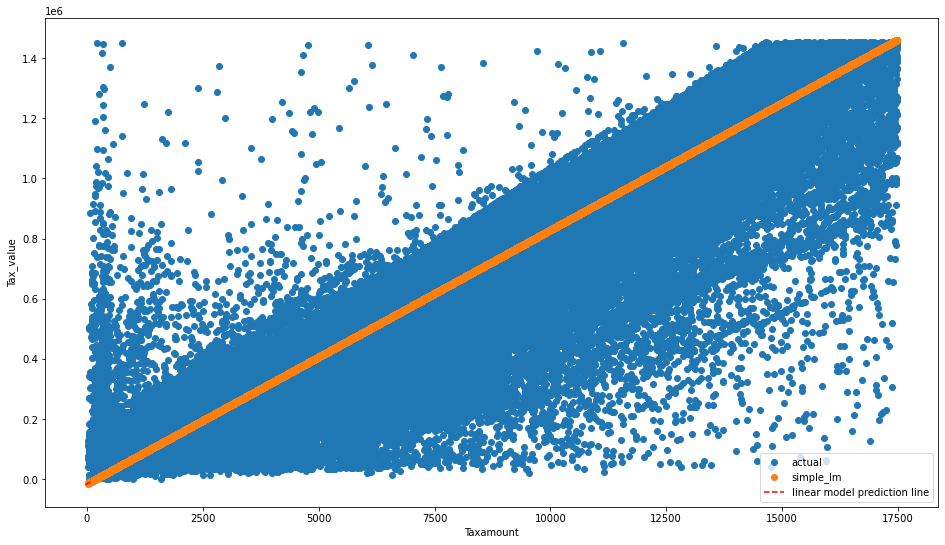

In [11]:
x_pred = np.array([-25, 100]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(16, 9))
plt.scatter(train.taxamount, train.tax_value, label='actual')
plt.scatter(train.taxamount, lm.predict(train[['taxamount']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='red', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')

plt.xlabel('Taxamount')
plt.ylabel('Tax_value')
plt.legend()

In [12]:
print('tax_value = {:.3f} * taxamount + {:.3f}'.format(lm.coef_[0], lm.intercept_))

tax_value = 84.518 * taxamount + -16365.690


In [13]:
train.tax_value.max()

1454758.0

In [14]:
taxamount = np.arange(train.taxamount.min(), train.taxamount.max())
tax_value = lm.predict(taxamount.reshape(-1, 1))
pd.DataFrame(dict(taxamount=taxamount, predicted_home_value=tax_value))

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,taxamount,predicted_home_value
0,16.48,-1.497283e+04
1,17.48,-1.488831e+04
2,18.48,-1.480379e+04
3,19.48,-1.471927e+04
4,20.48,-1.463475e+04
...,...,...
17463,17479.48,1.460972e+06
17464,17480.48,1.461057e+06
17465,17481.48,1.461142e+06
17466,17482.48,1.461226e+06


### Multiple Regression + RFE

In [15]:
X_train = train.drop(columns=['tax_value','fips','yearbuilt'])
y_train = train.tax_value
X_validate = validate.drop(columns=['tax_value','fips','yearbuilt'])

lm = LinearRegression()
k = 2

# 1. Transform our X
rfe = RFE(lm, n_features_to_select=2)
rfe.fit(X_train, y_train)
print('selected top 2 features:', X_train.columns[rfe.support_])
X_train_rfe = rfe.transform(X_train)

selected top 2 features: Index(['bedroom', 'bathroom'], dtype='object')


In [16]:
X_train.shape

(1145530, 5)

In [17]:
X_train_rfe.shape

(1145530, 2)

In [18]:
# 2. Use the transformed x in our model
lm.fit(X_train_rfe, y_train)

# 3. Make predictions
X_validate_rfe = rfe.transform(X_validate)
predictions['multiple_rfe'] = lm.predict(X_validate_rfe)

predictions.head()

,actual,simple_lm,multiple_rfe
1292142,224327.0,216633.023808,340649.388370
2058386,146000.0,204330.521354,355188.019470
1883615,489000.0,481736.907417,419780.457533
1580431,269076.0,253885.366359,355188.019470
711630,104263.0,111585.069010,340649.388370


In [19]:
# look into models make up
lm.coef_, lm.intercept_

(array([-14538.63109986, 158262.1383257 ]), 82279.63611829915)

In [20]:
print(f'tax_value = {lm.coef_[0]:.2f} x bedroom + {lm.coef_[1]:.2f} x bathroom + {lm.intercept_:.2f}')

tax_value = -14538.63 x bedroom + 158262.14 x bathroom + 82279.64


In [21]:
X = pd.DataFrame({
    'bedrooms': train.bedroom,
    'bathrooms': train.bathroom
})

X['predicted_tax_value'] = lm.predict(X)
X

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


,bedrooms,bathrooms,predicted_tax_value
717802,3.0,1.0,196925.881144
664602,3.0,3.0,513450.157796
91875,2.0,1.0,211464.512244
1390318,5.0,3.0,484372.895596
1287692,3.0,2.0,355188.019470
...,...,...,...
122849,3.0,2.0,355188.019470
1505697,4.0,2.0,340649.388370
105279,4.0,2.0,340649.388370
1188418,4.0,3.0,498911.526696


### Polynomial Degree 2 interactions_only = False

In [47]:
train.columns

Index(['bedroom', 'bathroom', 'squarefeet', 'tax_value', 'yearbuilt',
       'taxamount', 'fips', 'home_age'],
      dtype='object')

In [50]:
X = train[[ 'bathroom' 
     ,'home_age']]
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
vif_data

,feature,VIF
0,bathroom,2.846139
1,home_age,2.846139


In [22]:
train.columns.to_list()

['bedroom',
 'bathroom',
 'squarefeet',
 'tax_value',
 'yearbuilt',
 'taxamount',
 'fips',
 'home_age']

In [100]:
X_train = train[['home_age', 'bathroom']]
X_validate = validate[['home_age', 'bathroom']]
y_train = train.tax_value
y_validate = validate.tax_value

# 1. Generate Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)
X_train_poly.head()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,home_age,bathroom,home_age^2,home_age bathroom,bathroom^2
717802,66.0,1.0,4356.0,66.0,1.0
664602,67.0,3.0,4489.0,201.0,9.0
91875,76.0,1.0,5776.0,76.0,1.0
1390318,70.0,3.0,4900.0,210.0,9.0
1287692,60.0,2.0,3600.0,120.0,4.0


In [101]:
# 2. Use the features
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate)
predictions['polynomial degree 2'] = lm.predict(X_validate_poly)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [102]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,lasso_lars,glm,baseline
1292142,224327.0,216633.023808,340649.388370,326048.897160,218137.044548,217589.148219,374484.104664,374484.104664
2058386,146000.0,204330.521354,355188.019470,323312.185350,205414.504261,205400.176187,374484.104664,374484.104664
1883615,489000.0,481736.907417,419780.457533,478368.168085,478144.012549,481963.931138,374484.104664,374484.104664
1580431,269076.0,253885.366359,355188.019470,334955.980385,255640.807326,254497.717281,374484.104664,374484.104664
711630,104263.0,111585.069010,340649.388370,326048.897160,113649.924466,113510.600966,374484.104664,374484.104664


### Polynomial Degree 2 interactions_only = True

In [103]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X.columns),
    index=train.index,
)
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate)
predictions['polynomial only interaction'] = lm.predict(X_validate_poly)

pd.Series(lm.coef_, index=poly.get_feature_names(X_train.columns)).sort_values()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


home_age bathroom     -1682.017528
home_age               3352.822927
bathroom             237333.296033
dtype: float64

In [104]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,lasso_lars,glm,baseline
1292142,224327.0,216633.023808,340649.388370,326048.897160,337868.564308,217589.148219,374484.104664,374484.104664
2058386,146000.0,204330.521354,355188.019470,323312.185350,337801.291536,205400.176187,374484.104664,374484.104664
1883615,489000.0,481736.907417,419780.457533,478368.168085,446073.007801,481963.931138,374484.104664,374484.104664
1580431,269076.0,253885.366359,355188.019470,334955.980385,337980.685595,254497.717281,374484.104664,374484.104664
711630,104263.0,111585.069010,340649.388370,326048.897160,337868.564308,113510.600966,374484.104664,374484.104664


### Lasso-Lars

In [105]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

# Add lassolars predictions to our predictions DataFrame
predictions['lasso_lars'] = X_validate_pred_lars

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [106]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

home_age      -427.550008
bathroom    141369.188883
dtype: float64

In [107]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,lasso_lars,glm,baseline
1292142,224327.0,216633.023808,340649.388370,326048.897160,337868.564308,354588.571295,374484.104664,374484.104664
2058386,146000.0,204330.521354,355188.019470,323312.185350,337801.291536,352023.271246,374484.104664,374484.104664
1883615,489000.0,481736.907417,419780.457533,478368.168085,446073.007801,443230.266078,374484.104664,374484.104664
1580431,269076.0,253885.366359,355188.019470,334955.980385,337980.685595,358864.071376,374484.104664,374484.104664
711630,104263.0,111585.069010,340649.388370,326048.897160,337868.564308,354588.571295,374484.104664,374484.104664


### Generalized Linear Model

In [108]:
X_train

,home_age,bathroom
717802,66.0,1.0
664602,67.0,3.0
91875,76.0,1.0
1390318,70.0,3.0
1287692,60.0,2.0
...,...,...
122849,38.0,2.0
1505697,38.0,2.0
105279,62.0,2.0
1188418,102.0,3.0


In [109]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data
glm.fit(X_train, y_train)

# predict validate
X_validate_predict_glm = glm.predict(X_validate)

# Add lassolars predictions to our predictions DataFrame
predictions['glm'] = X_validate_predict_glm

In [110]:
# look into models make up
pd.Series(glm.coef_, index=X_train.columns).sort_values()

home_age   -0.001839
bathroom    0.339405
dtype: float64

In [111]:
glm.intercept_

12.161737500977829

In [112]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,lasso_lars,glm,baseline
1292142,224327.0,216633.023808,340649.388370,326048.897160,337868.564308,354588.571295,340917.725265,374484.104664
2058386,146000.0,204330.521354,355188.019470,323312.185350,337801.291536,352023.271246,337176.485196,374484.104664
1883615,489000.0,481736.907417,419780.457533,478368.168085,446073.007801,443230.266078,436411.901933,374484.104664
1580431,269076.0,253885.366359,355188.019470,334955.980385,337980.685595,358864.071376,347245.601566,374484.104664
711630,104263.0,111585.069010,340649.388370,326048.897160,337868.564308,354588.571295,340917.725265,374484.104664


# Baseline

In [113]:
# add a baseline model
predictions['baseline'] = train.tax_value.mean()

In [114]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,lasso_lars,glm,baseline
1292142,224327.0,216633.023808,340649.388370,326048.897160,337868.564308,354588.571295,340917.725265,374484.104664
2058386,146000.0,204330.521354,355188.019470,323312.185350,337801.291536,352023.271246,337176.485196,374484.104664
1883615,489000.0,481736.907417,419780.457533,478368.168085,446073.007801,443230.266078,436411.901933,374484.104664
1580431,269076.0,253885.366359,355188.019470,334955.980385,337980.685595,358864.071376,347245.601566,374484.104664
711630,104263.0,111585.069010,340649.388370,326048.897160,337868.564308,354588.571295,340917.725265,374484.104664


In [121]:
predictions.baseline

1292142    374484.104664
2058386    374484.104664
1883615    374484.104664
1580431    374484.104664
711630     374484.104664
               ...      
1683927    374484.104664
225709     374484.104664
1123364    374484.104664
137198     374484.104664
1740079    374484.104664
Name: baseline, Length: 490942, dtype: float64

## Evaluate

In [115]:
def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

predictions.apply(calculate_mse).sort_values()

actual                         0.000000e+00
simple_lm                      3.713505e+09
polynomial degree 2            5.324814e+10
polynomial only interaction    5.363406e+10
glm                            5.379896e+10
multiple_rfe                   5.469613e+10
lasso_lars                     5.473376e+10
baseline                       6.948912e+10
dtype: float64

# Actual Vs Predicted

/opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


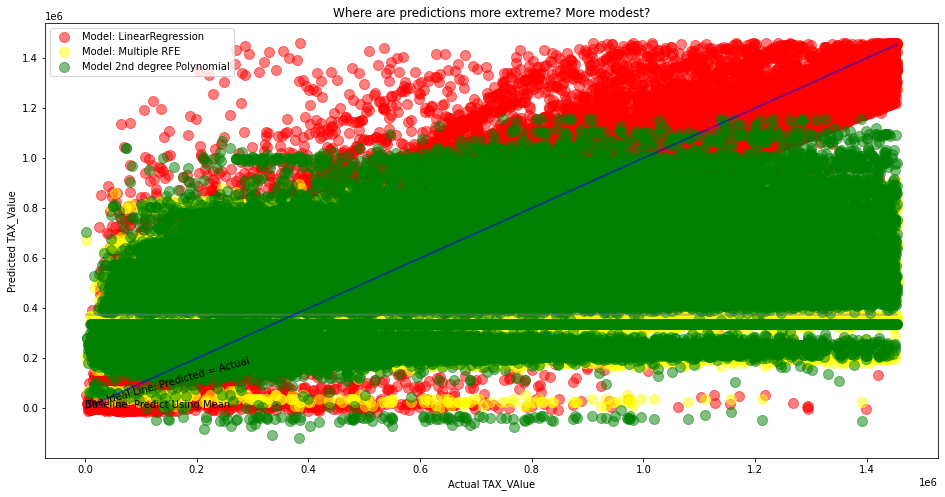

In [123]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate, predictions.baseline, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate, y_validate, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate, predictions.simple_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate, predictions.multiple_rfe, 
            alpha=.5, color="yellow", s=100, label="Model: Multiple RFE")
plt.scatter(y_validate, predictions['polynomial only interaction'], 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual TAX_VAlue")
plt.ylabel("Predicted TAX_Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


# Residual Plots

In [125]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,lasso_lars,glm,baseline
1292142,224327.0,216633.023808,340649.388370,326048.897160,337868.564308,354588.571295,340917.725265,374484.104664
2058386,146000.0,204330.521354,355188.019470,323312.185350,337801.291536,352023.271246,337176.485196,374484.104664
1883615,489000.0,481736.907417,419780.457533,478368.168085,446073.007801,443230.266078,436411.901933,374484.104664
1580431,269076.0,253885.366359,355188.019470,334955.980385,337980.685595,358864.071376,347245.601566,374484.104664
711630,104263.0,111585.069010,340649.388370,326048.897160,337868.564308,354588.571295,340917.725265,374484.104664


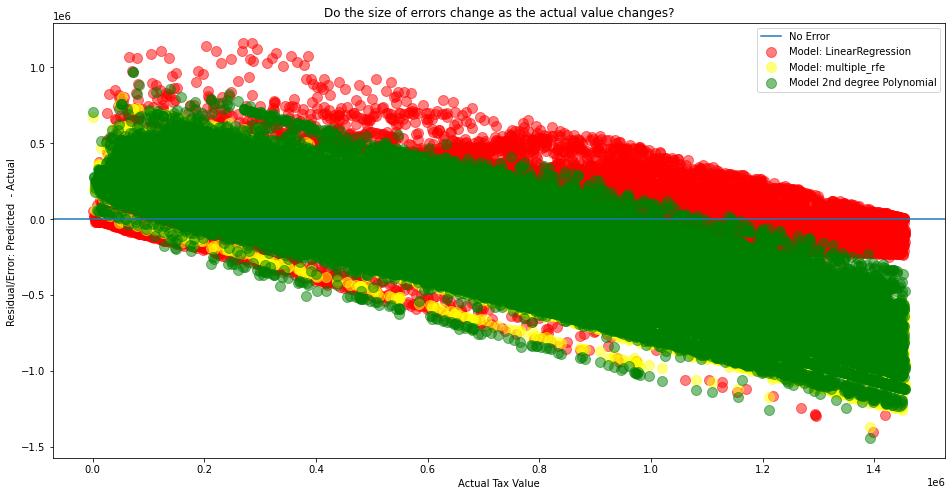

In [130]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate, predictions.simple_lm-y_validate, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate, predictions.multiple_rfe-y_validate, 
            alpha=.5, color="yellow", s=100, label="Model: multiple_rfe")
plt.scatter(y_validate,predictions['polynomial only interaction']- y_validate, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted  - Actual ")
plt.title("Do the size of errors change as the actual value changes?")
#plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
#plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

# Histograms

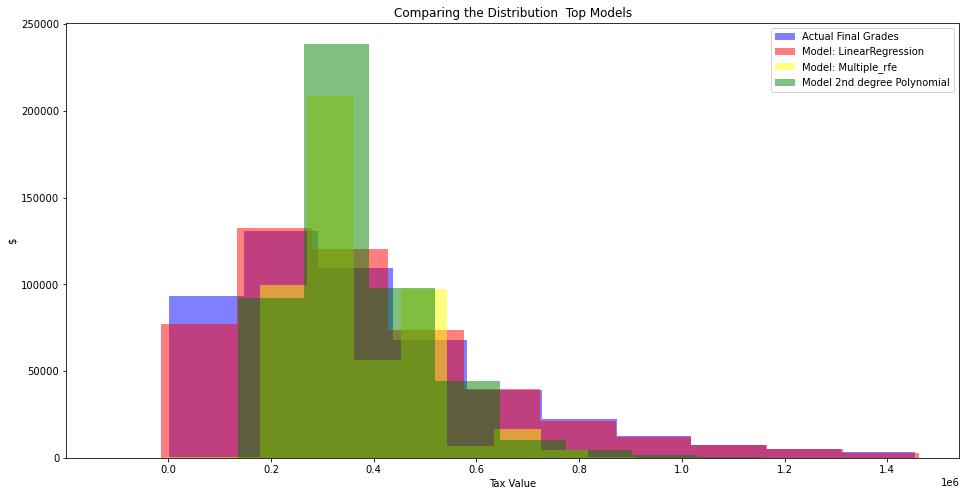

In [134]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(predictions.simple_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(predictions.multiple_rfe, color='yellow', alpha=.5, label="Model: Multiple_rfe")
plt.hist(predictions['polynomial only interaction'], color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Value")
plt.ylabel("$")
plt.title("Comparing the Distribution  Top Models")
plt.legend()
plt.show()